# Control variates for a GARCH model

Ce notebook répond à la **première question** du projet. En suivant les directives de l'article, on implémente un échantillonneur de Metropolis-Hastings basé sur une marche aléatoire pour estimer les paramètres d'un modèle GARCH(1,1). On commence par l'utilisation de données simulées, puis on étend l'analyse à des données réelles. Ces données réelles sont des rendements logarithmiques des taux de change, dont la source est donnée ci-après.

## Importation des libraries

In [2]:
! pip install arch
! pip install numpy 
! pip install matplotlib
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 KB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 31.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 12.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 26.7 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.6 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm

## Échantillonnage des données simulées selon un modèle Normal-GARCH(1,1)  

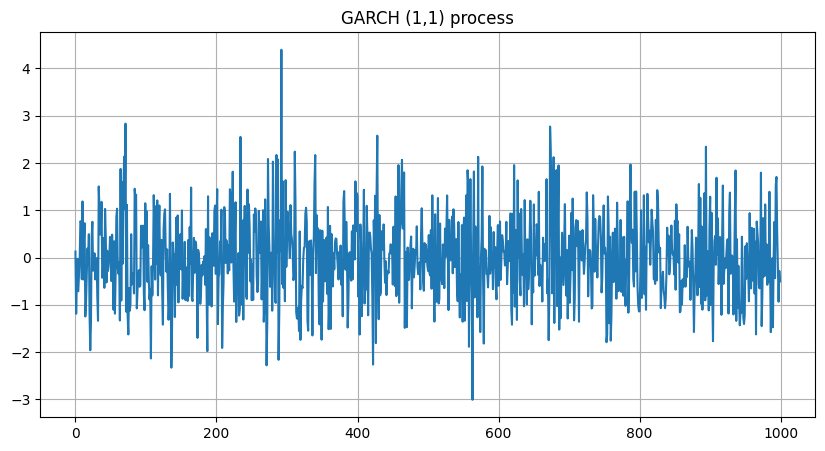

In [4]:
np.random.seed(12345)

n = 1000        # n le nombre d'observations à générer
n1 = 100        # n1 est le nombre des observations premières qu'on supprime de l'échantillon 
n2 = n + n1     # n2 est le nombre de simulations total

# Les paramètres de GARCH(1,1)
omega = 0.1
alpha = 0.2   
beta = 0.7

errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega

for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]

h = h2[n1-1:-1]
y = r[n1-1:-1]    # On élimine les premières observations

plt.figure(figsize=(10, 5))
plt.title('GARCH (1,1) process')
x = range(n) 
plt.plot(x,y)
plt.grid(True)
plt.show()

## Récupération des données réelles 

On calcule la transformation logarithmique du taux de change Euro/US Dollar journalier sur la période entre 24/04/2021 et 24/04/2024.

- Source : https://www.investing.com/currencies/eur-usd-historical-data

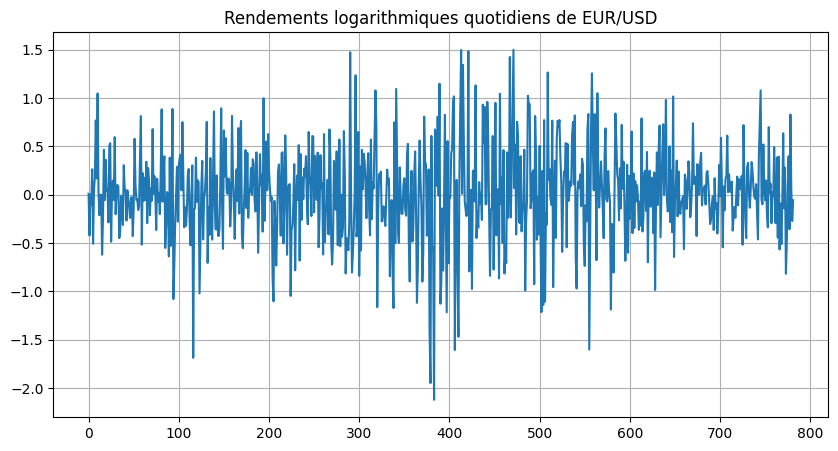

In [5]:
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)

plt.figure(figsize=(10, 5))
plt.title('Rendements logarithmiques quotidiens de EUR/USD')
x = range(len(r)) 
plt.plot(x,r)
plt.grid(True)
plt.show()

## Metropolis-Hastings sampler

1. **Implémentation de la distribution à priori (priors) :**

Nous choisissons une loi normale pour chaque paramètre $ \omega_i $. Les paramètres $ \omega_1 $, $ \omega_2 $ et $ \omega_3 $ sont supposés être indépendants. Nous sélectionnons de grandes variances pour que la distribution à posteriori reflète principalement les données et non nos propres croyances.

2. **Implémentation de la vraisemblance :**

Dans un modèle GARCH(1,1), les rendements sont conditionnellement distribués selon une loi normale, $ r(t)|F_t \sim N(0, h_t) $, où $ h_t $ est donné par :

$$
h_t = \omega_1 + \omega_3 h_{t-1} + \omega_2 r_{t-1}^2
$$

La fonction de vraisemblance est donnée par :

$$
l(\omega_1, \omega_2, \omega_3|r) \propto \prod_{t=1}^{T} h_t^{-\frac{1}{2}} \exp \left( -\frac{1}{2} \sum_{t=1}^{T} \frac{r_t^2}{h_t} \right)
$$

En utilisant des lois à priori normales et indépendantes pour les paramètres, la loi à posteriori est donnée par :

$$
\pi(\omega_1, \omega_2, \omega_3|r) \propto \exp \left( -\frac{1}{2} \left( \frac{\omega_1^2}{\sigma^2(\omega_1)} + \frac{\omega_2^2}{\sigma^2(\omega_2)} + \frac{\omega_3^2}{\sigma^2(\omega_3)} \right) \right) \prod_{t=1}^{T} h_t^{-\frac{1}{2}} \exp \left( -\frac{1}{2} \sum_{t=1}^{T} \frac{r_t^2}{h_t} \right)
$$

3. **Implémentation de l'algorithme Metropolis :** 
Nous générons ensuite un échantillon de triplets $ \omega_1 $, $ \omega_2 $ et $ \omega_3 $ qui cible la distribution à posteriori du modèle GARCH(1,1). Pour ce faire, nous avons besoin de la matrice de variance-covariance $\Sigma_\pi$ de la loi cible soit la distribution à posteriori qu'on ignore. <br>

    a. Dans un premier temps, nous utilisons l'approche adaptive MCMC où $\Sigma_\pi$ est estimée par $c*\hat{\Sigma}$ où c est une constante à déterminer et $\hat{\Sigma}$ est la matrice de variance-covariance de l'échantillon de taille t-1, déjà généré à l'étape t. Elle se met à jour avec chaque itération. La constante c est choisie de façon à avoir un acceptance rate autour de 0.5.  <br>
    
    b. Dans un deuxième temps, nous choisissons $\Sigma_\pi$ de la forme $\sigma*I_3$ et nous choisissons $\sigma$ de façons à avoir un acceptance rate autour de 0.5.


In [6]:
# 1. Distribution a priori de (w1, w2, w3)

def prior(omega, var):
    """
        omega (list): le vecteur des paramètres [w1,w2,w3]
        var (list): le vecteur des variances des lois normales
    """
    P = 1
    for i in range (len(omega)):
            P = P* np.exp(-0.5 * (omega[i]**2/var[i]))
    return P


# 2. Fonction de log-vraisemblance conditionnelle du modèle GARCH log(L(r/w))

def likelihood(returns, omega):
    T = 100
    h = np.zeros(T)
    h[0] = 1.4128118384007489 # à la première valeur de h on associe la variance des taux d'intérêt.
    
    for t in range(1, T):
        h[t] = omega[0] + omega[2] * h[t-1] + omega[1] * (returns[t-1] ** 2)
    L = np.prod((10/np.sqrt(h)) * np.exp(-0.5*(np.array(returns[:100])**2)/h))
    return L


#  Distribution à posteriori

def posterior (returns, omega, var) :
    return prior (omega,var) * likelihood(returns,omega)

In [10]:
# 3.a Echantillonage Metropolis avec adaptive MCMC


# Probabilité de transition de x vers y et de y vers x 

def q(x, y, sigma):
    if np.linalg.det(sigma) == 0 :
        return 1
    else :
        sigma_inv = np.linalg.inv(sigma)
        q = (1 / (np.sqrt((2 * np.pi)**3 * np.linalg.det(sigma)))) * np.exp(-0.5 * np.dot(np.dot((y - x).T, sigma_inv), (y - x)))
        return q

def metropolis (returns, omega_current, n_iter, var, c):
    
    # On initialise le nombre d'omegas acceptés dans l'algorithme
    j = 0 

    # omega_matrix est la matrice de notre échantillon, on stocke la valeur initiale du vecteur omega
    omega_matrix = omega_current 

    # c*sigma est un estimateur de la matrice de variance-covariance de la distribution à posteriori
    # On initialise sigma par la matrice identité, elle sera actualisé par la méthode 'adaptive MCMC'
    sigma = np.eye(3) 
    np.random.seed(12)
    for i in range (0,n_iter):

        # Proposer un nouveau jeu de paramètres omega_n qui correspond à Y et omega_current c'est Xn-1.
        omega_n = omega_current + abs(np.random.multivariate_normal(np.array([0,0,0]), sigma*c))

        # Calcul de r(x, y) ; Dans notre cas, q_ratio = 1
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)

        # Affectation de la valeur de Xn : Xn = Y avec une proba = min (1,r)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1

        # Ajout du nouveau vecteur des omégas à notre matrice 
        omega_matrix = np.vstack((omega_matrix, omega_current)) 

        # On centre notre échantillon
        mean_X = np.mean(omega_matrix, axis=0)
        centered_omega = omega_matrix - mean_X

        # Actualisation de la matrice de variance-covariance empirique sigma avec 'adaptive MCMC'
        sigma = np.cov(centered_omega, rowvar=False)
    
    # j/n_iter est le taux d'acceptation et omega_matrix est notre échantillon pour une valeur donnée de c
    return j/n_iter, centered_omega
    
def c_optimal (returns, omega_current, n_iter,var, a, b):

    # T est une liste qui stocke les taux d'acceptation pour plusieurs valeurs de c
    T=[] 

    # on se donne un certain nombre de valeurs de c dans un intervalle [a,b]
    C = np.linspace(a,b,1000) 
    
    for c in C :
        taux = metropolis (returns, omega_current, n_iter, var, c)[0]
        T.append (taux)

    plt.plot(C,T)
    plt.show()
    return T


Choix de la constante c optimale pour les données simulées y 

In [ ]:
J = c_optimal (y, np.array([1,1,1]), 10000,[1,1,1], 0.001, 0.01)
# En regardant le taux d'acceptance pour différentes valeurs de c, la valeur de c qui donne un taux d'acceptance de l'ordre de 0.25 est 
# c* = 1/5000

Visualisation des échantillons Metropolis avec adaptive MCMC en utilisant les données simulées 

1.0


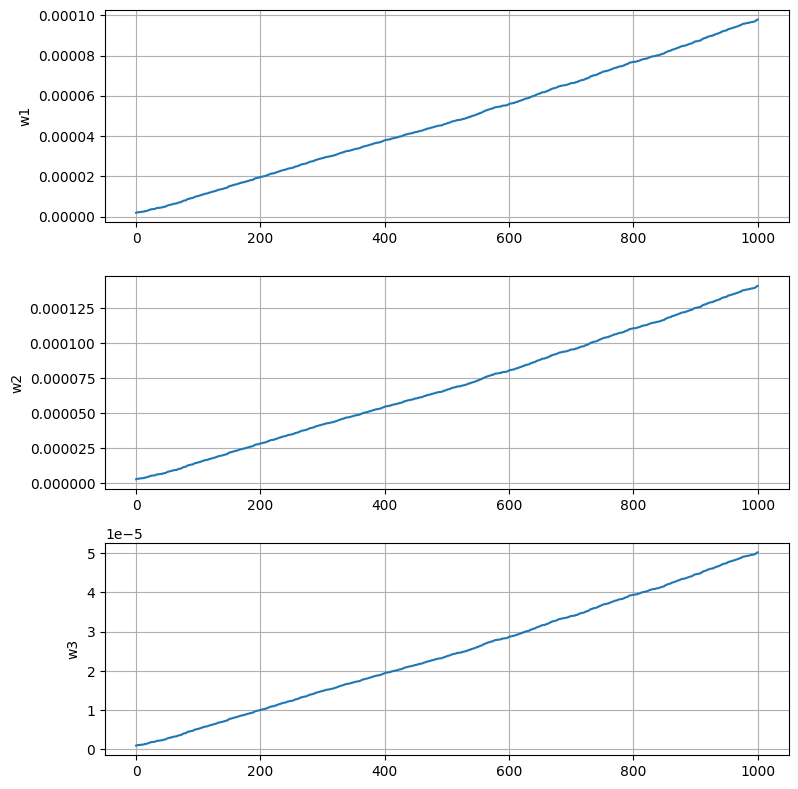

In [21]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 2000
c_etoile = 1/200000

echant_sim1 = metropolis (y, omega_current, n_iter, var, c_etoile)[1]
accept_rate = metropolis (y, omega_current, n_iter, var, c_etoile)[0]
# print(accept_rate)


fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(1001), echant_sim1[1000:, 0])
axs[0].set_ylabel('w1')
axs[0].grid()

axs[1].plot(range(1001), echant_sim1[1000:, 1])
axs[1].set_ylabel('w2')
axs[1].grid()

axs[2].plot(range(1001), echant_sim1[1000:, 2])
axs[2].set_ylabel('w3')
axs[2].grid()

plt.tight_layout()
plt.show()

Comme nous pouvons le voir, les échantillons générés sont très lisses pour correspondre à des trajectoires de chaines de Markov. Ceci est dû probablement à l'estimation de la matrice $\Sigma_\pi$ par $c*\hat{\Sigma}$ où $\hat{\Sigma}$ est définie à partir de tous les triplets déjà générés, c'est-à-dire que le futur dépend de tout le passé. Ceci est incompatible avec la propriété de Markov : le futur ne dépend du passé (toute la trajectoire) qu'à travers le présent.  <br>

Pour résoudre ce problème, nous choisissons la matrice $\Sigma_\pi$ constante et de la forme $\sigma*I_3$ par souci de simplicité où $\sigma$ est déterminé de façons à avoir un acceptance rate entre 0.2 et 0.8. Nous déterminons ainsi un bon candidat pour $\sigma$ et nous générons ensuite nos échantillons.

In [24]:
# 3.b Echantillonage Metropolis avec une matrice de variance-convarice de pi ocnstante

def metropolis2 (returns, omega_current, n_iter, var, sigma):
    
    j = 0 

    omega_matrix = omega_current 
    np.random.seed(12)

    for i in range (0,n_iter):

        omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        
        while np.any(omega_n <=0 ) :
            omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)

        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1
        omega_matrix = np.vstack((omega_matrix, omega_current)) 
    
    return j/n_iter, omega_matrix


def sigma_optimal (returns, omega_current, n_iter,var, a, b):

    # T est une liste qui stocke les taux d'acceptation pour plusieurs valeurs de c
    T=[] 

    # on se donne un certain nombre de valeurs de c dans un intervalle [a,b]
    S = np.linspace(a,b,100) 
    
    for sigma in S :
        taux = metropolis2 (returns, omega_current, n_iter, var, sigma)[0]
        T.append (taux)

    plt.plot(S,T)
    plt.ylabel("Taux d'acceptation")
    plt.xlabel('sigma')
    plt.show()
    return T


Choix du sigma optimal pour un taux d'acceptation autour de 0.5

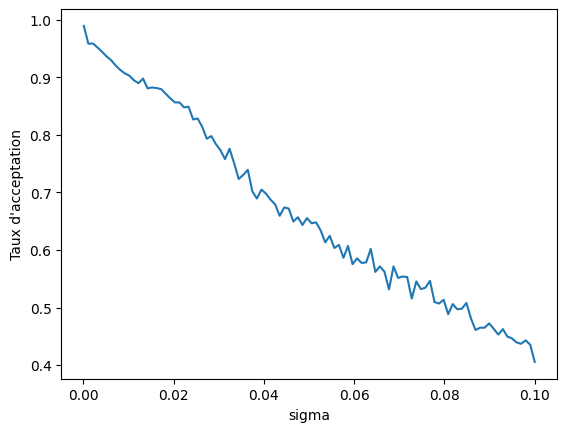

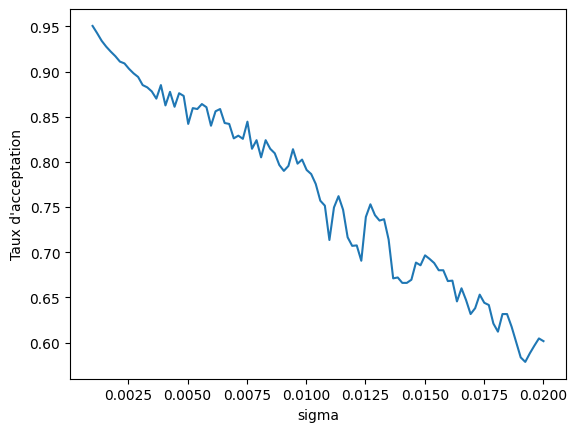

Pour les données simulées : 
 La valeur de sigma optimale est 0.1.
 Elle donne un taux d'acceptation de 0.4055
Pour les données réelles : 
 La valeur de sigma optimale est 0.019195959595959596.
 Elle donne un taux d'acceptation de 0.5785


In [26]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000


T_sim = sigma_optimal (y, omega_current, 2000 ,var, 0.0001, 0.1)
T_reel = sigma_optimal (r, omega_current, 2000 ,var, 0.001, 0.02)

T1_min = min(T_sim) 
i_sim = T_sim.index(T1_min)
P1 = np.linspace(0.0001,0.1,100)
Sigma_opt_sim = P1[i_sim]
print('Pour les données simulées : \n La valeur de sigma optimale est ' + str(Sigma_opt_sim) + ".\n Elle donne un taux d'acceptation de "+ str(T1_min))

T2_min = min(T_reel) 
i_reel = T_reel.index(T2_min)
P2 = np.linspace(0.0001,0.02,100)
Sigma_opt_reel = P2[i_reel]
print("Pour les données réelles : \n La valeur de sigma optimale est " + str(Sigma_opt_reel) + ".\n Elle donne un taux d'acceptation de "+ str(T2_min))


Visualisation des échantillons Metropolis avec $\Sigma_\pi = \sigma*I_3$ en utilisant les données simulées 

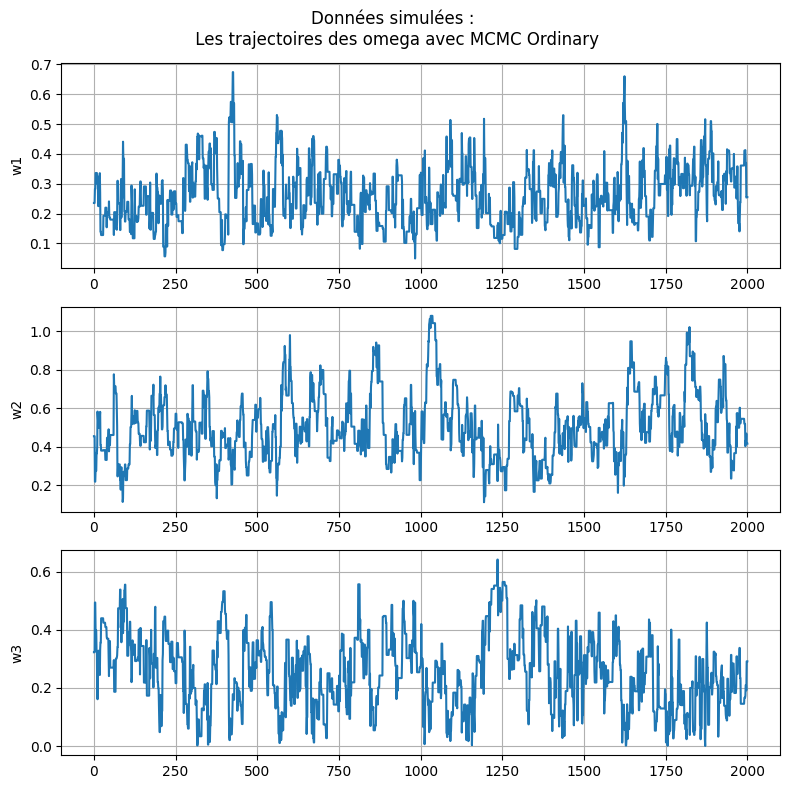

Le taux d'acceptation est égal à 0.4206666666666667


In [30]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 3000

echant_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[1]


# Visualisation de l'évolution des paramètres à partir des données simulées avec un burn-in de 1000 observations

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(2001), echant_sim[1000:, 0])
axs[0].set_ylabel('w1')
axs[0].grid()

axs[1].plot(range(2001), echant_sim[1000:, 1])
axs[1].set_ylabel('w2')
axs[1].grid()

axs[2].plot(range(2001), echant_sim[1000:, 2])
axs[2].set_ylabel('w3')
axs[2].grid()

plt.suptitle("Données simulées : \n Les trajectoires des omega avec MCMC Ordinary")
plt.tight_layout()
plt.show()

accep_rate_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[0]
print("Le taux d'acceptation est égal à " + str(accep_rate_sim))

Visualisation des échantillons Metropolis avec $\Sigma_\pi = \sigma*I_3$ en utilisant les données réelles 

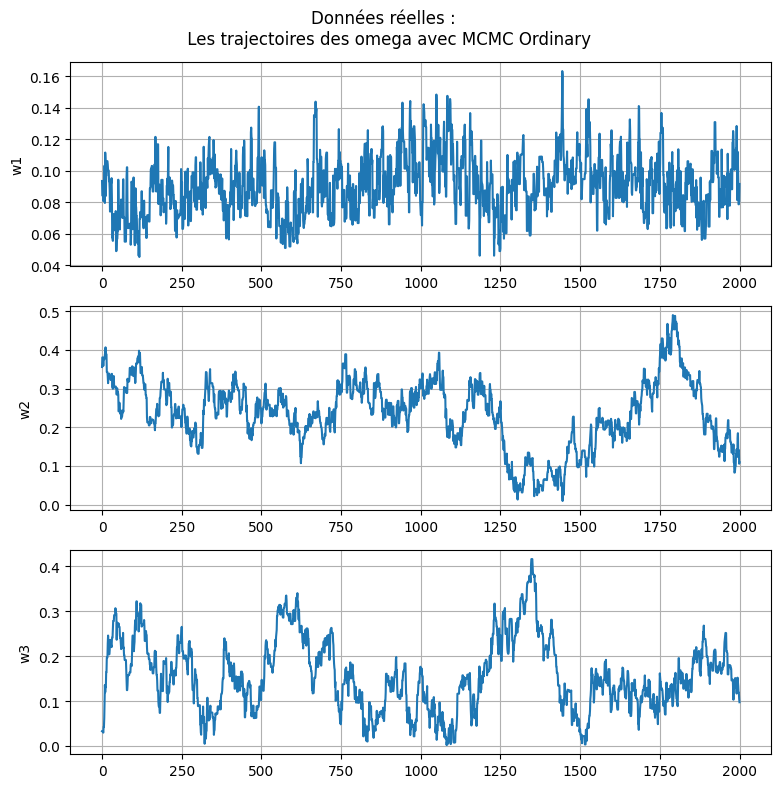

Le taux d'acceptation est égal à 0.19233333333333333


In [33]:
echant_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[1]

# Visualisation de l'évolution des paramètres à partir des données simulées avec un burn-in de 1000 observations

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(2001), echant_reel[1000:, 0])
axs[0].set_ylabel('w1')
axs[0].grid()

axs[1].plot(range(2001), echant_reel[1000:, 1])
axs[1].set_ylabel('w2')
axs[1].grid()

axs[2].plot(range(2001), echant_reel[1000:, 2])
axs[2].set_ylabel('w3')
axs[2].grid()

plt.suptitle("Données réelles : \n Les trajectoires des omega avec MCMC Ordinary")
plt.tight_layout()
plt.show()


accep_rate_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_sim)[0]
print("Le taux d'acceptation est égal à " + str(accep_rate_reel))


Nous effectuons ensuite des statistiques descriptives sur les échantillons générés.

In [35]:
def confidence_intervals(mean, se, z_value=1.96):
    lower_bound = mean - z_value * se
    upper_bound = mean + z_value * se
    return lower_bound, upper_bound

def stat_descrip(echant):
    # Calcul des moyennes
    mean_o1 = np.mean(echant[:,0])
    mean_o2 = np.mean(echant[:,1])
    mean_o3 = np.mean(echant[:,2])

    # Calcul des erreurs standards empiriques
    se_o1 = np.std(echant[:,0]) / np.sqrt(len(echant[:,0]))
    se_o2 = np.std(echant[:,1]) / np.sqrt(len(echant[:,1]))
    se_o3 = np.std(echant[:,2]) / np.sqrt(len(echant[:,2]))

    # Calcul des intervalles de confiance à 95%
    ci_o1 = confidence_intervals(mean_o1, se_o1)
    ci_o2 = confidence_intervals(mean_o2, se_o2)
    ci_o3 = confidence_intervals(mean_o3, se_o3)

    # Affichage des résultats
    print("La moyenne de omega1 est autour :" + str(mean_o1))
    print("L'intervalle de confiance de omega1 est donné par :"+ str(ci_o1))
    print("\n")
    print("La moyenne de omega2 est autour :", mean_o2)
    print("L'intervalle de confiance de omega1 est donné par :"+ str(ci_o2))
    print("\n")
    print("La moyenne de omega3 est autour :", mean_o3)
    print("L'intervalle de confiance de omega3 est donné par :"+ str(ci_o3))
    print("\n")


In [38]:
print("---------------------------- Pour les données simulées --------------------------------")
print("\n")
stat_descrip(echant_sim)

print("\n")
print("---------------------------- Pour les données réelles --------------------------------")
stat_descrip(echant_reel)


---------------------------- Pour les données simulées --------------------------------
La moyenne de omega1 est autour :0.2528352627740057
L'intervalle de confiance de omega1 est donné par :(0.24936612944643044, 0.25630439610158096)
La moyenne de omega2 est autour : 0.4952613692560701
L'intervalle de confiance de omega1 est donné par :(0.48904265602011276, 0.5014800824920275)

La moyenne de omega3 est autour : 0.27166219450522067
L'intervalle de confiance de omega3 est donné par :(0.26672375806400545, 0.2766006309464359)


---------------------------- Pour les données réelles --------------------------------
La moyenne de omega1 est autour :0.08307323320165133
L'intervalle de confiance de omega1 est donné par :(0.08207780388028627, 0.0840686625230164)
La moyenne de omega2 est autour : 0.23739381416449493
L'intervalle de confiance de omega1 est donné par :(0.2336716986035887, 0.24111592972540116)

La moyenne de omega3 est autour : 0.2181526962656785
L'intervalle de confiance de omega3 

En guise de simplicité, nous importons les données des rendements réeelles $ r $ et simulées $y$ ainsi que les échantillons du vecteur $ \boldsymbol{\omega} = (\omega_1, \omega_2, \omega_3) $ générés à partir des données simulées **echant_sim** et des données réelles **echant_reel** , qui nous seront utiles pour les notebooks suivants.


In [ ]:
import pickle

var_dict = {
    'y': y,
    'r': r,
    'h': h, 
    'echant_sim' : echant_sim,
    'echant_reel' : echant_reel
}

with open('donnees.pkl', 'wb') as f:
    pickle.dump(var_dict, f)
